# Jakub Bandurski, Michał Bryzik, Kacper Gruca
## Text Mining and Social Media Mining Project
## Can sentiment analysis predict the subreddit r/AITA top comment verdict?
## What are the most common topics on this subreddit?

# Imports

In [2]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Load data

In [2]:
data = pd.read_pickle("./data/cleaned_data.pkl")
data.head(1)

,title_body_no_stopwords,C1_no_stopwords,title_body_stemmed,C1_stemmed,AITA
0,left marriage selfish right happy think thats ...,three months since bfs split wife didnt divorc...,left marriage selfish right happy think thats ...,three months since bfs split wife didnt divorc...,True


# Calculate VADER score
We are using a standard method of extracting the sentiment from the comments - VADER score.

Usually the cut offs for the VADER score are:

- Postive above 0.05
- Negative below -0.05
- Neutral in between

As the verdict of the reddit hive-mind can be either Yes or No we are going to assume that neutral sentiment corresponds to NTA.

In [6]:
# move to sentiment analysis
def calculate_sentiment_score(sentence, analyser):
    snt = analyser.polarity_scores(sentence)  #call the polarity analyzer
    return snt["compound"]

Calculate VADER score for all the comments - both stemmed and not stemmed versions.

In [10]:
data["C1_no_stopwords_sentiment"] = data["C1_no_stopwords"].apply(lambda x: calculate_sentiment_score(sentence=x,analyser=analyser))
data["C1_stemmed_sentiment"] = data["C1_stemmed"].apply(lambda x: calculate_sentiment_score(sentence=x,analyser=analyser))
data.head(1)

,title_body_no_stopwords,C1_no_stopwords,title_body_stemmed,C1_stemmed,AITA,C1_no_stopwords_sentiment,C1_stemmed_sentiment
0,left marriage selfish right happy think thats ...,three months since bfs split wife didnt divorc...,left marriage selfish right happy think thats ...,three months since bfs split wife didnt divorc...,True,0.2023,0.2023


### Assign the True or False label based on VADER score

In [20]:
def calculate_vader_verdict(x):
    if x > 0.05:
        # positive -> NTA -> false
        return False
    elif x< -0.05:
        # negative -> YTA -> true
        return True
    else:
        # neutral -> NTA -> false
        return False

Translate VADER score to a 'verdict' which means labels True (YTA) and False (NTA)

In [21]:
# VADER scale:
# > 0.05 positive
# [-0.05, 0.05] neutral
# < -0.05 negative

data["C1_no_stopwords_AITA"] = data["C1_no_stopwords_sentiment"].apply(lambda x: calculate_vader_verdict(x))
data["C1_stemmed_sentiment_AITA"] = data["C1_stemmed_sentiment"].apply(lambda x: calculate_vader_verdict(x))
data.to_pickle("./data/vader_scores.pkl")
data.head(1)

,title_body_no_stopwords,C1_no_stopwords,title_body_stemmed,C1_stemmed,AITA,C1_no_stopwords_sentiment,C1_stemmed_sentiment,C1_no_stopwords_AITA,C1_stemmed_sentiment_AITA
0,left marriage selfish right happy think thats ...,three months since bfs split wife didnt divorc...,left marriage selfish right happy think thats ...,three months since bfs split wife didnt divorc...,True,0.2023,0.2023,False,False


# Calculating error metrics

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

data = pd.read_pickle("./data/vader_scores.pkl")

## Calculate metrics

In [7]:
# Create a DataFrame to store the results of the sentiment analysis
results = pd.DataFrame(columns=["stemmed", "non-stemmed"], index=["accuracy", "precision", "recall", "f1", "roc_auc"])

# Calculate and store the accuracy of the stemmed and non-stemmed data
results.loc["accuracy", "stemmed"] = accuracy_score(data["AITA"], data["C1_stemmed_sentiment_AITA"])
results.loc["accuracy", "non-stemmed"] = accuracy_score(data["AITA"], data["C1_no_stopwords_AITA"])

# Calculate and store the precision of the stemmed and non-stemmed data
results.loc["precision", "stemmed"] = precision_score(data["AITA"], data["C1_stemmed_sentiment_AITA"])
results.loc["precision", "non-stemmed"] = precision_score(data["AITA"], data["C1_no_stopwords_AITA"])

# Calculate and store the recall of the stemmed and non-stemmed data
results.loc["recall", "stemmed"] = recall_score(data["AITA"], data["C1_stemmed_sentiment_AITA"])
results.loc["recall", "non-stemmed"] = recall_score(data["AITA"], data["C1_no_stopwords_AITA"])

# Calculate and store the F1 score of the stemmed and non-stemmed data
results.loc["f1", "stemmed"] = f1_score(data["AITA"], data["C1_stemmed_sentiment_AITA"])
results.loc["f1", "non-stemmed"] = f1_score(data["AITA"], data["C1_no_stopwords_AITA"])

# Calculate and store the ROC AUC score of the stemmed and non-stemmed data
results.loc["roc_auc", "stemmed"] = roc_auc_score(data["AITA"], data["C1_stemmed_sentiment_AITA"])
results.loc["roc_auc", "non-stemmed"] = roc_auc_score(data["AITA"], data["C1_no_stopwords_AITA"])

# Save the results DataFrame to a pickle file
results.to_pickle("./data/metrics.pkl")

# Display the results DataFrame
results


,stemmed,non-stemmed
accuracy,0.586946,0.586946
precision,0.265989,0.265989
recall,0.414571,0.414571
f1,0.32406,0.32406
roc_auc,0.527802,0.527802


We can conclude from the dataframe above that although the VADER scores are different for stemmed and non-stemmed data, the accuracy, precision, recall, F1 score and ROC AUC score are the same. 

This means that stemming does not affect the performance of the VADER sentiment analysis.

Moreover there is no change in classification of the comments for YTA and NTA.

Let us calculate the confusion matrix and discuss the metrics.

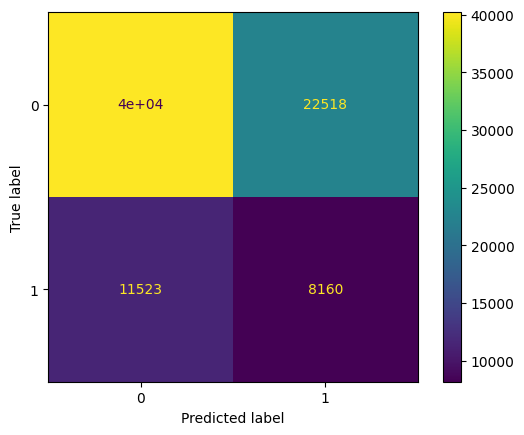

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(data["AITA"], data["C1_stemmed_sentiment_AITA"])

# Print the confusion matrix
ConfusionMatrixDisplay(cm).plot()

We need to know if the dataset is balanced in order to properly interpret the metrics.

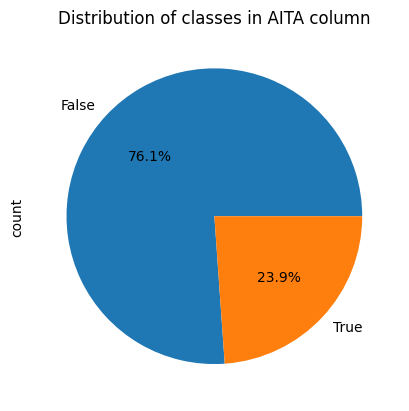

In [20]:
import matplotlib.pyplot as plt

# Calculate the value counts
counts = data["AITA"].value_counts()

# Create a pie chart
counts.plot.pie(autopct='%1.1f%%')

# Add a title to the plot
plt.title('Distribution of classes in AITA column')

# Show the plot
plt.show()

# Metrics discussion


Firstly, we have a imbalanced dataset with 76% of the data being NTA and 24% of YTA answers which means that we cannot use accuracy as a valid metric.

Secondly, we have a very low precision score of 27% which means that the model is not very good at predicting YTA answers.

Thirdly, we have a recall score of 42% which means that the model is not very good at predicting NTA answers either.

The F1 score is 33% which indicates poor performance of our approach.

The ROC AUC score is 53% which is only 3 percentage points more than a random chance model.



# Conclusions


Based on the quantitative sentiment analysis of the comments, we can see that the sentiment of the comment does not have a strong correlation with the AITA label.

Comments can be mean and negative, but not necessarily say that the poster is YTA. By the same logic comments can be positive and nice, but not necessarily say that the poster is NTA.

The sentiment analysis using a VADER sentiment score is not a good predictor of the AITA label. Therfore we suggest that further reasearch could be performed using other sentiment techniques.
